
# Business Analysis

Fernando Soares Goudard

The task is to help a company optimize its marketing expenses. We received server logs with data on visits to Y.Afisha from January 2017 to December 2018, a dump file with all orders placed during this period, and marketing expense statistics.

The following will be analyzed:

    How people use the product
    When they start buying
    How much money each customer brings to the company
    When expenses will be covered

Reports and metrics calculations will be made:

Product

    How many people use it each day, week, and month?
    How many sessions occur per day? (A user can have multiple sessions.)
    How long is each session?
    How often do users return?

Sales

    When do people start buying?
    How many orders do customers place during a given period of time?
    What is the average purchase volume?
    How much money do they bring to the company (LTV)?

Marketing

    How much money was spent? In total/by source/over time
    How much did customer acquisition cost for each source?
    Were the investments worthwhile? (ROI)



In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data import

Before we begin, let's take a quick look at a small sample of the data to verify the correct formats for the different columns. Since we will be working with large sets, this initial correction will speed up our future processes.

In [56]:
df_visits_log = pd.read_csv('visits_log_us.csv',nrows=500)
df_orders_log = pd.read_csv('orders_log_us.csv',nrows=500)
df_costs = pd.read_csv('costs_us.csv',nrows=500)

In [57]:
print('df_visits_log')
df_visits_log.info()
print(df_visits_log.head())

df_visits_log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 19.7+ KB
    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820

* 'device' -> convert category
* 'End Ts' -> transformar em datetime "%Y-%m-%d %H:%m:%s"
* 'Start Ts' -> transformar em datetime "%Y-%m-%d %H:%m:%s"

In [58]:
print('df_orders_log')
df_orders_log.info()
print(df_orders_log.head())

df_orders_log
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   500 non-null    object 
 1   Revenue  500 non-null    float64
 2   Uid      500 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 11.8+ KB
                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450


* 'Buy Ts' -> convert to datetime "%Y-%m-%d %H:%m:%s"

In [59]:
print('df_costs')
df_costs.info()
print(df_costs.head())

df_costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  500 non-null    int64  
 1   dt         500 non-null    object 
 2   costs      500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB
   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08


* 'dt' -> convert to datetime "%Y-%m-%d"

I also think it is necessary to standardize the names of the visits and orders log columns.

In [60]:
df_visits_log = pd.read_csv('visits_log_us.csv',
                            dtype={'Device':'category'},
                            parse_dates=['Start Ts','End Ts'])
df_orders_log = pd.read_csv('orders_log_us.csv',
                            parse_dates=['Buy Ts'])
df_costs = pd.read_csv('costs_us.csv',
                       parse_dates=['dt'])

In [61]:
df_visits_log.columns = [s.strip().lower().replace(' ','_') for s in df_visits_log.columns]
df_orders_log.columns = [s.strip().lower().replace(' ','_') for s in df_orders_log.columns]

In [62]:
df_visits_log.info()
df_orders_log.info()
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 

Now we can start working on the data.

### Reports and metrics

##### Product:
* How many people use it each day, week, and month? (DAU, WAU, MAU)
* How many sessions occur per day? (One user can have multiple sessions.)
* How long is each session? (ASL)
* How often do users return? (Retention (weekly and monthly))

DAU WAU and MAU:

In [63]:
df_visits_log['session_date'] = df_visits_log['start_ts'].dt.normalize()
df_visits_log['session_week'] = df_visits_log['start_ts'].dt.isocalendar().week
df_visits_log['session_month'] = df_visits_log['start_ts'].dt.month
df_visits_log['session_year'] = df_visits_log['start_ts'].dt.year

In [64]:
dau_total = df_visits_log.groupby(['session_date']).agg({'uid':'nunique'})
wau_total = df_visits_log.groupby(['session_year','session_week']).agg({'uid':'nunique'})
mau_total = df_visits_log.groupby(['session_year','session_month']).agg({'uid':'nunique'})

print('Average people per day:',dau_total.values.mean())
print('Average people per week:',wau_total.values.mean())
print('Average people per month:',mau_total.values.mean())

Average people per day: 907.9917582417582
Average people per week: 5716.245283018868
Average people per month: 23228.416666666668


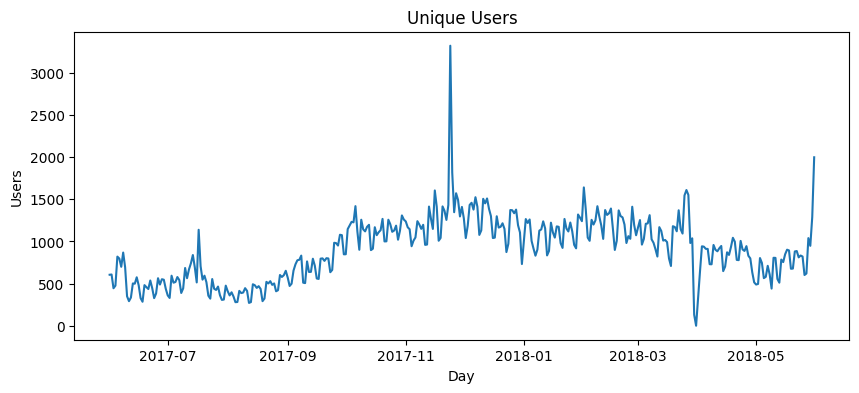

In [65]:
plt.subplots(figsize=(10,4))
fig = sns.lineplot(data = dau_total, x = 'session_date', y='uid')
fig.set_title('Unique Users')
fig.set_xlabel('Day')
fig.set_ylabel('Users')
plt.show()

We can see a very high peak on November 24, 2017, and a drop to zero on April 1, 2018.

In [66]:
wau_total.index=['_'.join(map(str, idx_tuple)) for idx_tuple in wau_total.index]


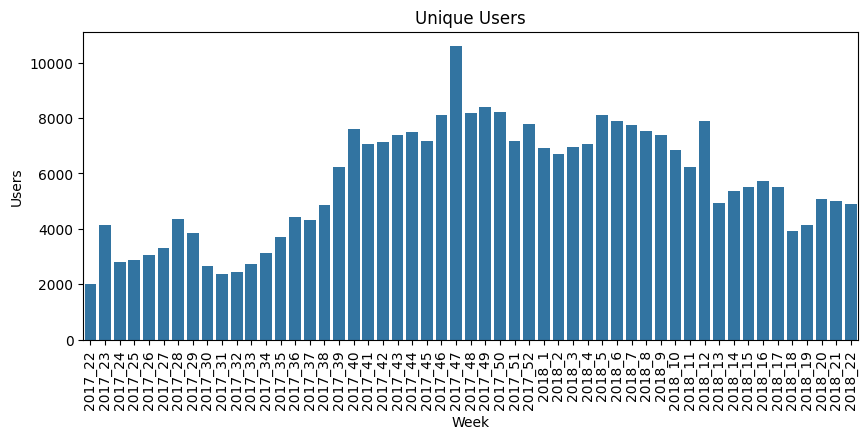

In [67]:
plt.subplots(figsize=(10,4))
fig = sns.barplot(data = wau_total, x = wau_total.index, y='uid')
fig.set_title('Unique Users')
fig.set_xlabel('Week')
fig.set_ylabel('Users')
plt.xticks(rotation=90)
plt.show()

In [68]:
mau_total.index=['_'.join(map(str, idx_tuple)) for idx_tuple in mau_total.index]


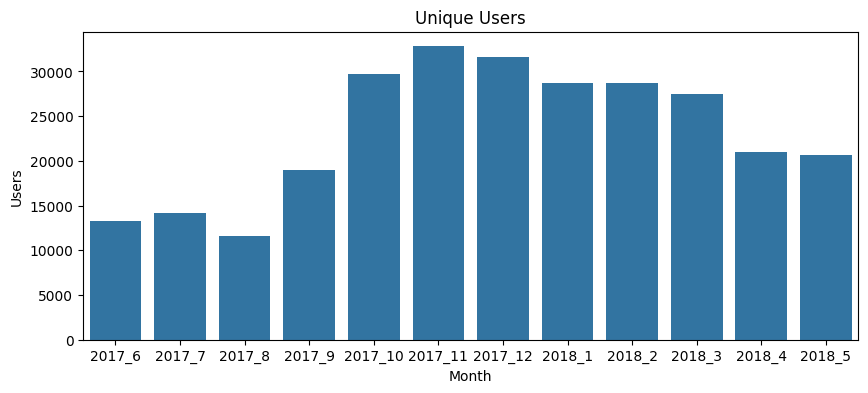

In [69]:
plt.subplots(figsize=(10,4))
fig = sns.barplot(data = mau_total, x = mau_total.index, y='uid')
fig.set_title('Unique Users')
fig.set_xlabel('Month')
fig.set_ylabel('Users')
plt.show()

Sessions per day:

In [70]:
session_day = df_visits_log.groupby(['session_date']).agg({'uid':'count'})

print('Average sessions per day:',session_day.values.mean())

Average sessions per day: 987.3626373626373


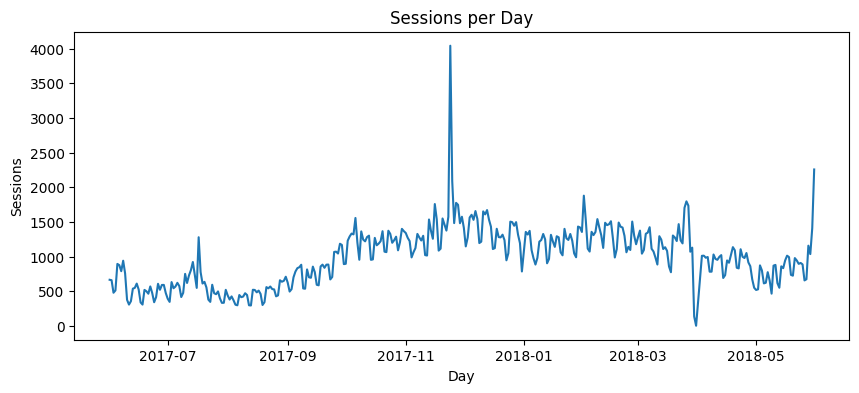

In [71]:
plt.subplots(figsize=(10,4))
fig = sns.lineplot(data = session_day)
fig.set_title('Sessions per Day')
fig.set_xlabel('Day')
fig.set_ylabel('Sessions')
plt.legend([],[],frameon=False)
plt.show()

How long is each session:

In [72]:
df_visits_log['session_duration_sec'] = (df_visits_log['end_ts'] - df_visits_log['start_ts']).dt.seconds


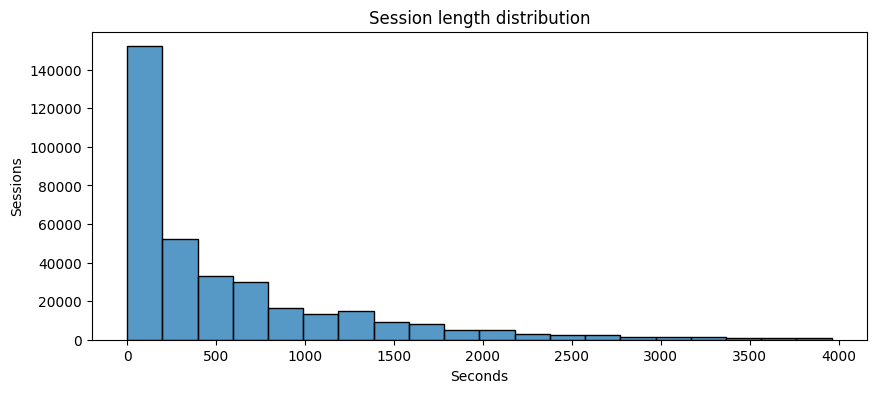

In [73]:
plt.subplots(figsize=(10,4))
fig = sns.histplot(data = df_visits_log[df_visits_log['session_duration_sec']<4000]['session_duration_sec'], bins=20)
fig.set_title('Session length distribution')
fig.set_xlabel('Seconds')
fig.set_ylabel('Sessions')
plt.show()

In [74]:
print('Average session length:', df_visits_log['session_duration_sec'].mode().values[0], 'seconds')

Average session length: 60 seconds


Retention (weekly and monthly)

In [75]:
print('Weekly retention factor:', dau_total.values.mean()/wau_total.values.mean()*100)
print('Monthly retention factor:', dau_total.values.mean()/mau_total.values.mean()*100)

Weekly retention factor: 15.88440861589881
Monthly retention factor: 3.908969652437603


In addition to using last year's average, we can also see how this factor has changed in a graph.

Let's first separate customers into cohorts.

Since the metric we want to evaluate is the retention factor, let's focus on the weekly factor to see the lifetime of the cohorts.

In [76]:
df_retention = df_visits_log[['session_date','uid']]
# let's filter the dataframes to check the date of each user's first visit

first_visit = df_retention.groupby('uid', as_index=False).agg({'session_date':'min'})

# now let's filter the first week by subtracting the day of the week from the date, 
# in order to obtain the Monday of the week of the first visit

first_visit['first_week'] = (pd.to_datetime(first_visit['session_date'], unit='d')
                             - pd.to_timedelta(first_visit['session_date'].dt.dayofweek, unit='d'))
# we will put the cohort values back into df_retention

df_retention = pd.merge(df_retention, first_visit[['uid','first_week']], how='left', on='uid')

# let's calculate the week of access
df_retention['session_week'] = (pd.to_datetime(df_retention['session_date'], unit='d')
                             - pd.to_timedelta(df_retention['session_date'].dt.dayofweek, unit='d'))

# The lifespan of cohorts
df_retention['cohort_lifetime'] = ((df_retention['session_week'] - df_retention['first_week'])/np.timedelta64(1,'W')).astype('int')


# and the initial number of users per cohort
cohorts = (
    df_retention.groupby(['first_week','cohort_lifetime'], as_index=False).agg({'uid':'nunique'})
)

# we performed the initial count of each cohort
initial_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_week','uid']]
initial_count.rename(columns={'uid':'cohort_users'},inplace=True)

# add the initial count to the cohort df
cohorts = pd.merge(cohorts, initial_count, how='left', on='first_week')

# calculate the weekly retention rate
cohorts['ret'] = cohorts['uid']/cohorts['cohort_users']

ret_pivot = cohorts.pivot_table(
    index='first_week',
    columns = 'cohort_lifetime',
    values = 'ret',
    aggfunc = 'sum'
)

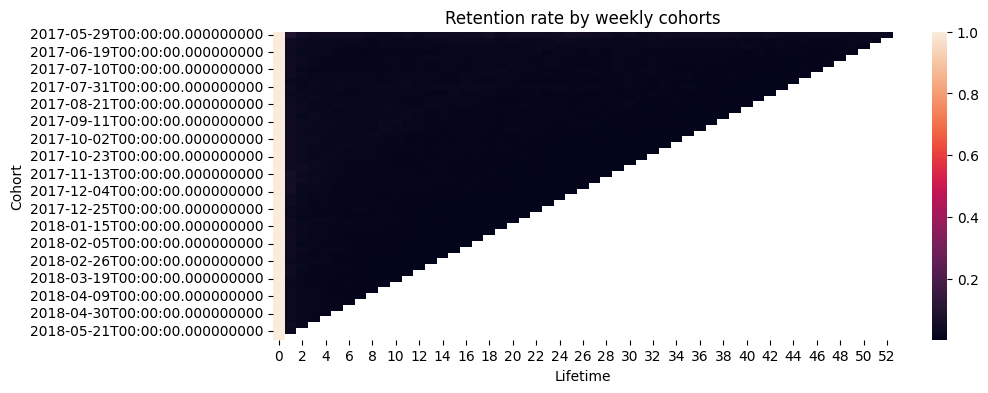

In [77]:
plt.subplots(figsize=(10,4))
fig = sns.heatmap(ret_pivot)
fig.set_title('Retention rate by weekly cohorts')
fig.set_xlabel('Lifetime')
fig.set_ylabel('Cohort')
plt.show()

We see very poor behavior; the vast majority of our customers only visit once, with less than 10% returning the following week.

One positive point is that our retention rate hardly changes after the second week, indicating that customers who visit again become loyal.

Let's see if this behavior changes when we look at the monthly retention rate.

In [78]:
# The np.timedelta64(1,'M') function has been deprecated in newer versions of numpy.
# To mimic its behavior, I will declare a variable with the days in the month and use it instead.

d_in_month = 30

In [79]:
df_retention = df_visits_log[['session_date','uid']]
# let's filter the dataframes to check the date of each user's first visit

first_visit = df_retention.groupby('uid', as_index=False).agg({'session_date':'min'})

# now let's filter the first month,
# in order to obtain the first day of the month of the visit

first_visit['first_month'] = first_visit['session_date'].dt.to_period('M').dt.to_timestamp().dt.date

# we will put the cohort values back into df_retention

df_retention = pd.merge(df_retention, first_visit[['uid','first_month']], how='left', on='uid')

# let's calculate the week of access
df_retention['session_month'] = df_retention['session_date'].dt.to_period('M').dt.to_timestamp().dt.date

# The lifespan of cohorts
df_retention['cohort_lifetime'] = ((df_retention['session_month'] - df_retention['first_month'])/np.timedelta64(d_in_month,'D')).astype('int')


# and the initial number of users per cohort
cohorts = (
    df_retention.groupby(['first_month','cohort_lifetime'], as_index=False).agg({'uid':'nunique'})
)

# perform the initial count of each cohort
initial_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_month','uid']]
initial_count.rename(columns={'uid':'cohort_users'},inplace=True)

# add the initial count to the cohort df
cohorts = pd.merge(cohorts, initial_count, how='left', on='first_month')

# calculate the weekly retention rate
cohorts['ret'] = cohorts['uid']/cohorts['cohort_users']

ret_pivot = cohorts.pivot_table(
    index='first_month',
    columns = 'cohort_lifetime',
    values = 'ret',
    aggfunc = 'sum'
)

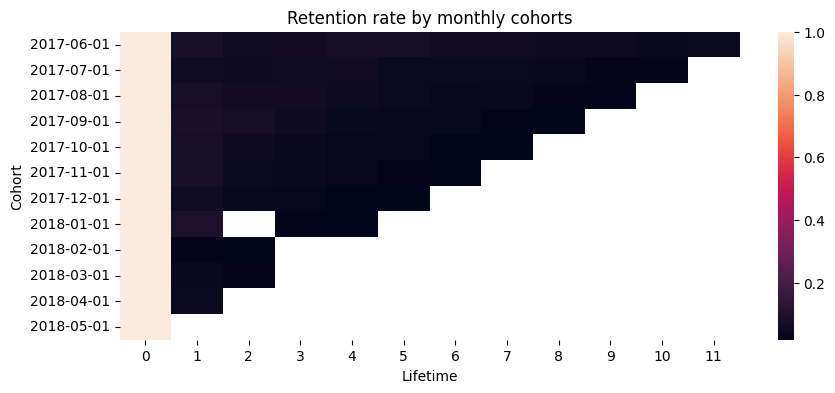

In [80]:
plt.subplots(figsize=(10,4))
fig = sns.heatmap(ret_pivot)
fig.set_title('Retention rate by monthly cohorts')
fig.set_xlabel('Lifetime')
fig.set_ylabel('Cohort')
plt.show()

We see the same behavior in monthly retention rates: the vast majority of our customers only log in once, with less than 10% returning the following month.

##### Sales
     
* When do people start buying? (time to buy)
* How many orders do customers place during a given period of time?
* What is the average purchase volume?
* How much money do they bring to the company (LTV)?

When people start buying:

let's start by separating customers from the visits dataframe to get the date of their first visit
let's do the same with the orders dataframe to get the date of their first purchase
we will use these two pieces of information to calculate the ttb in days

In [81]:
df_clients = df_visits_log.groupby('uid', as_index=False).agg({'start_ts':'min'})
df_clients.columns=['uid','first_session']
df_orders = df_orders_log.groupby('uid', as_index=False).agg({'buy_ts':'min'})
df_orders.columns=['uid','first_order']

df_ttb = df_clients.merge(df_orders, how='inner', on='uid')
df_ttb['ttb'] = (df_ttb['first_order']-df_ttb['first_session']).dt.days

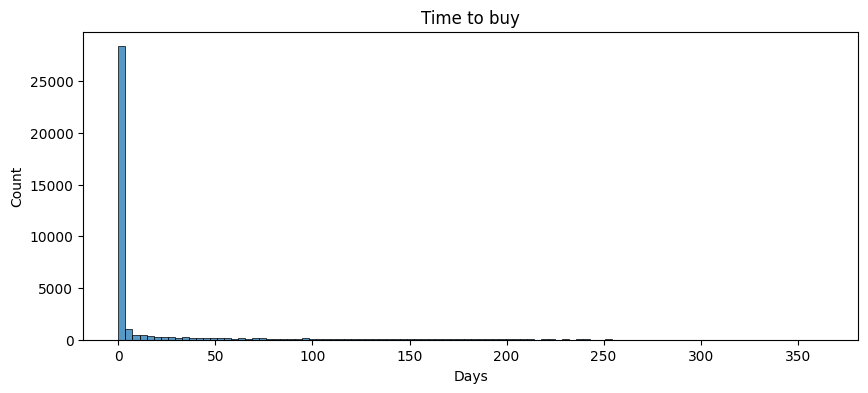

In [82]:
plt.subplots(figsize=(10,4))
fig = sns.histplot(data = df_ttb['ttb'], bins=100)
fig.set_title('Time to buy')
fig.set_xlabel('Days')
fig.set_ylabel('Count')
plt.show()

In [83]:
print('Average time to buy:', df_ttb['ttb'].mode().values[0], 'days')

Average time to buy: 0 days


Customers usually take less than 1 day to start buying!

How many orders do customers place during a given period of time?

In [84]:
# Let's perform the same monthly cohort analysis, but this time looking at repeat purchases

# Let's filter the dataframes to check the date of each user's first purchase

first_order = df_orders_log.groupby('uid', as_index=False).agg({'buy_ts':'min'})

# now let's filter the first month,
# in order to obtain the first day of the month of the visit

first_order['first_order_month'] = first_order['buy_ts'].dt.to_period('M').dt.to_timestamp()

# we will put the value of the cohorts back in df

df_orders_log = pd.merge(df_orders_log, first_order[['uid','first_order_month']], how='left', on='uid')

# let's calculate the month of purchase
df_orders_log['order_month'] = df_orders_log['buy_ts'].dt.to_period('M').dt.to_timestamp()

# The lifespan of cohorts
df_orders_log['cohort_lifetime'] = (((df_orders_log['order_month']
                                      - df_orders_log['first_order_month'])
                                    /np.timedelta64(d_in_month,'D')).astype('int'))


In [85]:

orders_pivot = df_orders_log.pivot_table(
    index='first_order_month',
    columns = 'cohort_lifetime',
    values = 'uid',
    aggfunc = 'count'
)

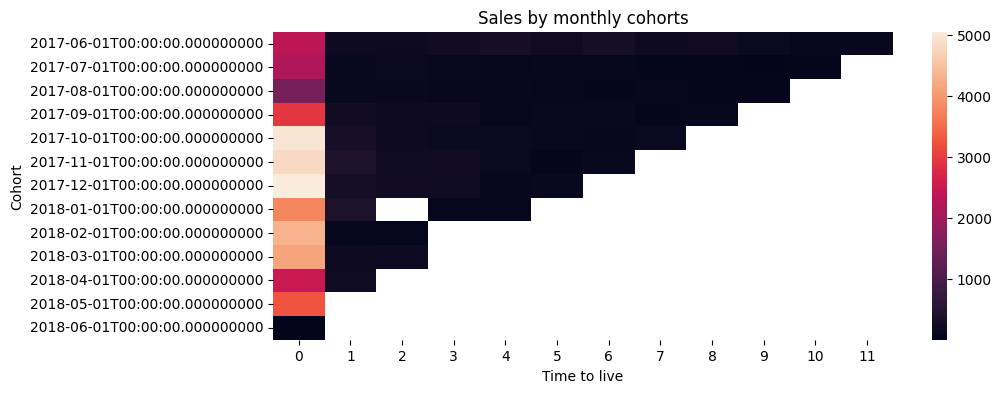

In [86]:
plt.subplots(figsize=(10,4))
fig = sns.heatmap(orders_pivot)
fig.set_title('Sales by monthly cohorts')
fig.set_xlabel('Time to live')
fig.set_ylabel('Cohort')
plt.show()

What is the average sale volume?

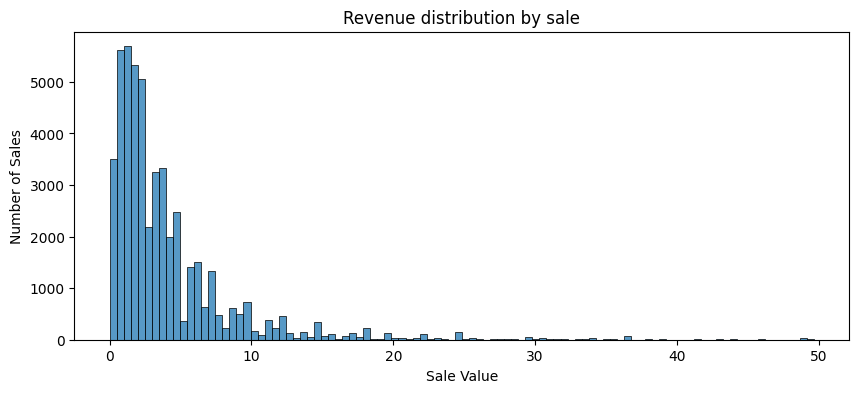

In [87]:
# Let's first look at the distribution of revenue by sales of our product.

plt.subplots(figsize=(10,4))
fig = sns.histplot(data = df_orders_log[df_orders_log['revenue'] < 50]['revenue'], bins=100)
fig.set_title('Revenue distribution by sale')
fig.set_xlabel('Sale Value')
fig.set_ylabel('Number of Sales')
plt.show()

In [88]:
print('Average revenue per sale:', df_orders_log['revenue'].mode().values[0])

Average revenue per sale: 1.83


How much money do they bring to the company (LTV)?

We don't know Y.Afisha's profit margin, so I'll assume it's 100%.

In [89]:
# let's determine the size of the cohorts
cohort_sizes = first_order.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.rename(columns={'uid':'n_buyers'},inplace=True)

# let's group purchases into cohorts to find out how much each cohort spends
buy_cohorts = df_orders_log.groupby(['first_order_month','order_month','cohort_lifetime']).agg({'revenue':'sum'}).reset_index()


In [90]:
user_source = df_visits_log[['uid','source_id']].drop_duplicates()

In [91]:

first_order = pd.merge(first_order, user_source, how='left', on='uid')
first_order.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57265 entries, 0 to 57264
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   uid                57265 non-null  uint64        
 1   buy_ts             57265 non-null  datetime64[ns]
 2   first_order_month  57265 non-null  datetime64[ns]
 3   source_id          57265 non-null  int64         
dtypes: datetime64[ns](2), int64(1), uint64(1)
memory usage: 1.7 MB


In [92]:
revenue_df = (df_orders_log.groupby(['uid','order_month'], as_index=False)
                .agg({'revenue':'sum'})
                .reset_index()
                .rename(columns={'order_month':'month'}))
buyers = first_order.merge(revenue_df, on='uid')

In [93]:
# let's calculate the month for each expense
df_costs['month'] = df_costs['dt'].dt.to_period('M').dt.to_timestamp()

revenue_grouped_df = buyers.groupby(['source_id','month']).agg({'revenue':'sum'}).reset_index()
costs_grouped_df = df_costs.groupby(['source_id','month']).agg({'costs':'sum'})

revenue_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  86 non-null     int64         
 1   month      86 non-null     datetime64[ns]
 2   revenue    86 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 KB


In [94]:
report_revision = pd.merge(
    costs_grouped_df,
    revenue_grouped_df,
    on=['source_id','month']
)
print(report_revision.head())

   source_id      month    costs   revenue
0          1 2017-06-01  1125.61   2563.84
1          1 2017-07-01  1072.88   3947.25
2          1 2017-08-01   951.81   3325.64
3          1 2017-09-01  1502.01   8193.42
4          1 2017-10-01  2315.75  11466.14


In [95]:
# let's determine the size of the cohorts
cohort_sizes = (first_order.groupby(['first_order_month','source_id'], as_index=False)
                .agg({'uid':'nunique'})
                .reset_index(drop=True))
cohort_sizes.rename(columns={'first_order_month':'month','uid':'n_buyers'}, inplace=True)
# and insert into the report
report_revision = report_revision.merge(cohort_sizes, on=['source_id','month'])
print(report_revision.head())
cohort_sizes.info()
buy_cohorts.info()

   source_id      month    costs   revenue  n_buyers
0          1 2017-06-01  1125.61   2563.84       401
1          1 2017-07-01  1072.88   3947.25       400
2          1 2017-08-01   951.81   3325.64       288
3          1 2017-09-01  1502.01   8193.42       526
4          1 2017-10-01  2315.75  11466.14       833
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   month      86 non-null     datetime64[ns]
 1   source_id  86 non-null     int64         
 2   n_buyers   86 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_order_month  79 non-null     datetime64[ns]
 1   order_month     

In [96]:

# We will create a report with this information to calculate the LTV per cohort and per month.
# From this, we can see how each cohort behaves and the average LTV.
cohort_sizes_=cohort_sizes.groupby('month', as_index=False).agg({'n_buyers':'sum'})
report = pd.merge(cohort_sizes_, buy_cohorts, left_on='month', right_on='first_order_month')

# Normally, we would calculate gross profit next, but I was not informed of the company's profit margin.
# So let's calculate the LTV directly.

report['ltv'] = report['revenue'] / report['n_buyers']

# let's organize the data in a dynamic table for visualization
result = report.pivot_table(
    index='first_order_month', columns='cohort_lifetime', values='ltv', aggfunc='mean'
).round()


result.cumsum(axis=1).round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,3.0,3.0,3.0,4.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0
2017-07-01,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,
2017-08-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,,
2017-09-01,3.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,,,
2017-10-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,,,,
2017-11-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,,,,,
2017-12-01,3.0,3.0,4.0,5.0,5.0,5.0,,,,,,
2018-01-01,3.0,3.0,,3.0,3.0,,,,,,,
2018-02-01,1.0,1.0,1.0,,,,,,,,,


In [97]:
# Let's calculate the average LTV for 6 months

mean_ltv = result.cumsum(axis=1).mean(axis=0)[5]
print('Average LTV (6 month period):', mean_ltv)

Average LTV (6 month period): 4.142857142857143


Marketing
     
* How much money was spent? In total/by source/over time
* How much did customer acquisition cost for each source?
* Were the investments worthwhile? (ROI)

In [98]:
print('Total costs:', df_costs['costs'].sum())

Total costs: 329131.62


In [99]:
# and organize expenses in a dynamic table to see how much we spend per month and per source
costs_pivot = df_costs.pivot_table(
    index = 'source_id',
    columns = 'month',
    values = 'costs',
    aggfunc = 'sum'
)
print(costs_pivot)

month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                               
1             1125.61     1072.88      951.81     1502.01     2315.75   
2             2427.38     2333.11     1811.05     2985.66     4845.00   
3             7731.65     7674.37     6143.54     9963.55    15737.24   
4             3514.80     3529.73     3217.36     5192.26     6420.84   
5             2616.12     2998.14     2185.28     3849.14     5767.40   
9              285.22      302.54      248.93      415.62      609.41   
10             314.22      329.82      232.57      460.67      627.24   

month      2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                               
1             2445.16     2341.20     2186.18     2204.48     1893.09   
2             5247.68     4897.80     4157.74     4474.34     3943.14   
3            17025.34    16219.52    14808.78    1

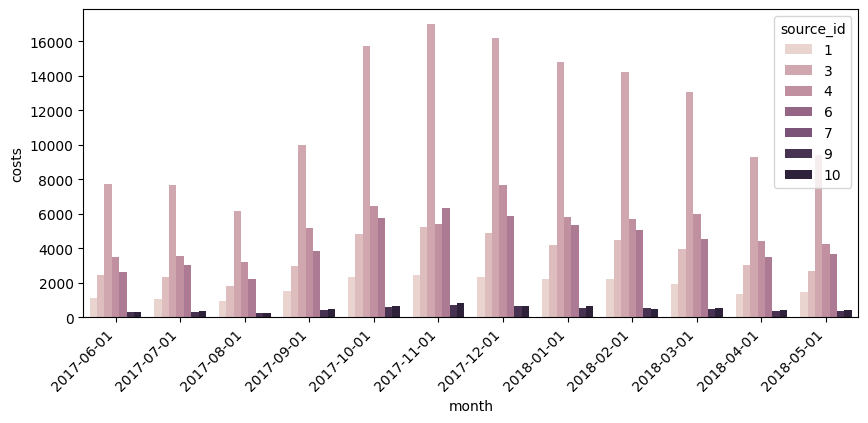

In [100]:
costs_graph = df_costs.groupby(['source_id','month'], as_index=False).agg({'costs':'sum'})
plt.subplots(figsize=(10,4))
fig = sns.barplot(data = costs_graph,
                   x = 'month',
                   y = 'costs',
                   hue = 'source_id')
plt.xticks(rotation=45, ha='right')
plt.show()

How much did customer acquisition cost for each source?

In [101]:
df_orders_log['buy_date'] = df_orders_log['buy_ts'].dt.normalize()
df_1 = df_orders_log[['uid','buy_date','order_month','revenue']].rename(columns={'buy_date':'date','order_month':'month'})
df_2 = (
    df_visits_log[df_visits_log['session_duration_sec']>0]
    .groupby(['session_date','uid'], as_index=False).agg({'source_id':'min'})
    .rename(columns={'session_date':'date'})
    )

In [102]:

client_cost = pd.merge(df_1, df_2, how='left', on=(['uid','date']))
client_cost = pd.merge(
    client_cost.groupby(['month','source_id'], as_index=False).agg({'uid':'count','revenue':'sum'}),
    df_costs.groupby(['month','source_id'], as_index=False).agg({'costs':'sum'}),
    how = 'inner',
    on = (['month','source_id'])
)
client_cost.rename(columns={'uid':'n_buyers'}, inplace=True)
client_cost['cost_per_client'] = client_cost['costs']/client_cost['n_buyers']

In [103]:
client_costs_pivot = client_cost.pivot_table(
    index = 'source_id',
    columns = 'month',
    values = 'cost_per_client'
)
print(costs_pivot)

month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                               
1             1125.61     1072.88      951.81     1502.01     2315.75   
2             2427.38     2333.11     1811.05     2985.66     4845.00   
3             7731.65     7674.37     6143.54     9963.55    15737.24   
4             3514.80     3529.73     3217.36     5192.26     6420.84   
5             2616.12     2998.14     2185.28     3849.14     5767.40   
9              285.22      302.54      248.93      415.62      609.41   
10             314.22      329.82      232.57      460.67      627.24   

month      2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                               
1             2445.16     2341.20     2186.18     2204.48     1893.09   
2             5247.68     4897.80     4157.74     4474.34     3943.14   
3            17025.34    16219.52    14808.78    1

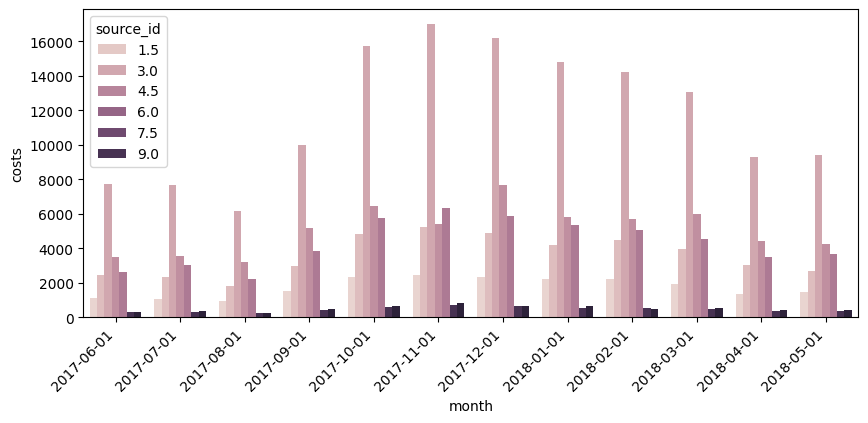

In [104]:
plt.subplots(figsize=(10,4))
fig = sns.barplot(data = client_cost,
                   x = 'month',
                   y = 'costs',
                   hue = 'source_id')
plt.xticks(rotation=45, ha='right')
plt.show()

In [105]:
print('Average cost per customer by source:')
print(client_cost.groupby('source_id')['cost_per_client'].mean())
print()
print(f'Remembering that we have an average LTV of: {mean_ltv} for a period of 6 months.')

Average cost per customer by source:
source_id
1.0      2.869080
2.0      7.339493
3.0     16.414450
4.0      6.954167
5.0      7.292047
9.0      6.701220
10.0     5.598062
Name: cost_per_client, dtype: float64

Remembering that we have an average LTV of: 4.142857142857143 for a period of 6 months.


In other words, sources 1, 4, 9, and 10 have a cost per customer below the expected return for 6 months. This indicates that we will need a little less than 6 months to start profiting from the customers acquired through these ads.

In [106]:
total_costs = df_costs['costs'].sum()
total_revenue = df_orders_log['revenue'].sum()
print('Total costs:', total_costs)
print('Total revenue:', total_revenue)

ROI_total = (total_revenue-total_costs)/total_costs
print('Total ROI:', ROI_total)

Total costs: 329131.62
Total revenue: 252057.19999999998
Total ROI: -0.2341750695360112


In [107]:
client_cost['roi'] = ((client_cost['revenue'] - client_cost['costs']) / client_cost['costs'])

print('ROI per advertiser in the last year:')
print(client_cost.groupby('source_id')['roi'].sum())

ROI per advertiser in the last year:
source_id
1.0     13.501277
2.0      0.026568
3.0     -9.094447
4.0     -4.644297
5.0     -4.296327
9.0     -5.951059
10.0    -5.437130
Name: roi, dtype: float64


In [108]:
# calcular o ltv
report_revision['ltv']=report_revision['revenue']/report_revision['n_buyers']
# calculr o CAC
report_revision['cac']=report_revision['costs']/report_revision['n_buyers']
# calcular o ROMI
report_revision['romi']=report_revision['ltv']/report_revision['cac']
# exibir em tabela
report_rev_pivot = report_revision.pivot_table(
    index='month',
    columns='source_id',
    values='romi',
    aggfunc='mean'
)
print(report_rev_pivot.cumsum(axis=1).round(2).fillna(''))

source_id     1      2      3      4      5      9      10
month                                                     
2017-06-01  2.28   3.58   4.12   5.24   6.45   9.09  10.47
2017-07-01  3.68   5.62   6.31   7.94   9.53  12.99  13.95
2017-08-01  3.49   5.18   5.82   7.04   8.81  13.17  14.99
2017-09-01  5.45   8.11   9.10  10.80  12.97  17.29  18.54
2017-10-01  4.95   7.42   8.20  10.07  11.96  15.96  17.47
2017-11-01  4.72   6.96   7.70  10.17  11.59  15.45  16.69
2017-12-01  8.04  12.08  13.41  16.31  19.84  23.15  24.10
2018-01-01  3.50   5.31   5.96   7.55   9.02  11.10  11.86
2018-02-01  4.04   6.64   7.40   9.43  11.93  14.56  15.96
2018-03-01  5.76   9.52  10.46  12.50  15.64  19.58  21.78
2018-04-01  5.16   7.75   8.60  10.48  12.81  16.25  17.98
2018-05-01  5.11   8.67   9.58  11.61  13.74  16.79  19.14


Here we can see that among all advertising sources, only sources 1 and 2 had a positive total ROI in the last year. We can see that source 1 has a return 10 times greater than the amount invested.

### Conclusion:

Looking at the metrics we have obtained, we can draw some interesting conclusions:

* First, we see that our product has very low customer retention. Almost all of our customers make only one purchase, or purchase only in the first month/week of using the product.
* Looking at the marketing statistics, we can see that our investments bring few results. Only two advertisers actually generate profits, while the others had a negative return in the year analyzed.

Source 3 has the highest total marketing cost, lowest return per CAC, and lowest total revenue. It is recommended to discontinue spending on this source. The best sources to invest in are sources 1 and 2, due to their high return per CAC and higher total revenues. Source 5 is also interesting due to its lower CAC and higher number of users attracted. The change in marketing spending should increase LTV, as users from sources 1 and 2 spend more.

There is a cycle of cohorts with good returns alternating with cohorts with poor returns. The September 2017 cohort achieved an excellent return, while subsequent cohorts had less satisfactory returns. It is important to seek to improve retention and identify why there are differences in cohort quality in order to reduce the time needed to achieve a return on investment.

Therefore, it is recommended to focus spending on sources 1, 2, and 5 for future investments and cut marketing expenses in the first months of the year, as they are not resulting in increased revenue per sale. It is recommended to allocate these resources to the last months of the year, which have the highest revenue per sale and per user.

In addition, September 2017, which had abnormally high LTV and ROMI, should be investigated to identify the cause and replication. It is important to focus on improving user retention, increasing conversion rates, and seeking strategies to increase the LTV of the most recent cohorts.